# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        x=float(x)
        y=float(y)
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

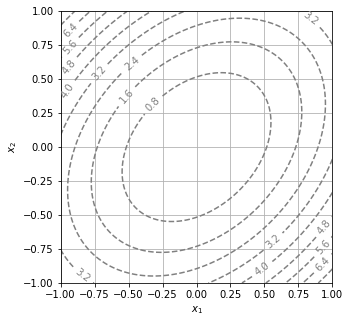

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

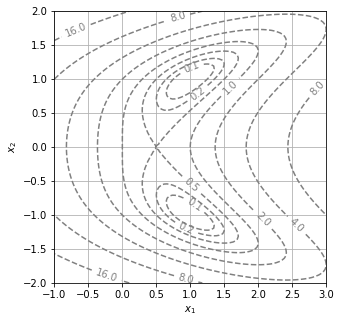

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

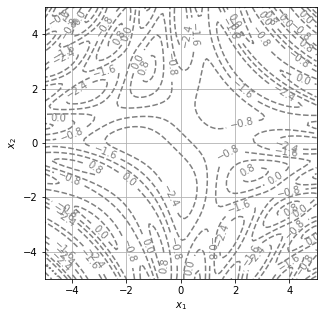

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 100
eps = 0.001 #On doit choisir un epsilon assez petit devant le "diamètre" de la courbe de niveau considérée.
            #Ici, on va fait des recherches de courbe pour des diamètres >1. 0.001 est donc assez petit
            #De plus, il ne faut pas prendre epsilon trop petit pour être plus grand que l'epsilon de l'ordinateur (ici en float il est aux alentours de 10**(-7))
            #0.001 est donc un bon compromis

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_f = J(F)
    for i in range(N):
        if np.linalg.det(J_f(x0, y0)) != 0 : # un test pour que le fonction continue de tourner même si la jacobienne n'est pas définie
            X = np.array([x0, y0]) - np.dot(np.linalg.inv(J_f(x0 ,y0)),F(x0 ,y0))
            x, y = X[0] ,X[1]
            if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps: #condition d'arrêt de la boucle
                return x, y
            x0, y0 = x, y
        else:
            return False
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

(0.4472135970019964, 0.4472135970019964)


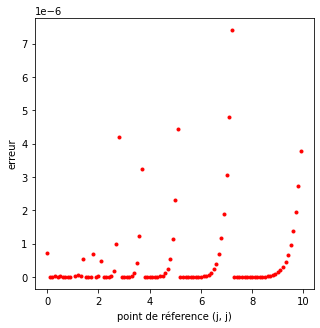

In [15]:
def F(x, y):
    return np.array([f1(x, y) - 0.8, x-y])

print(Newton(F, 0.8, 0.8, eps, N))

def graph_pt_ref():
    ref = [i / 10 for i in range(100)]
    erreur = []
    reuf = [] #liste pour laquelle l'initialistion "ref" ne crée pas pas un probleme où J est non inversible
    global c
    def F(x, y):
        return np.array([f2(x,y) - c, x - y])
    for j in ref:
        c = j
        Newtonin = Newton(F, j, j, eps, N) #on teste les points de référence de la forme (j,j)
        if Newtonin: #si le calcul de Newton a pu être fini, i.e pas de matrice non inversible
            a, b = Newtonin
            erreur.append(abs(c - f2(a, b)))
            reuf.append(j)
    plt.xlabel('point de réference (j, j)')
    plt.ylabel('erreur')
    plt.plot(reuf, erreur, "r.")

graph_pt_ref()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [16]:
def level_curve(f, x0, y0, c, delta = 0.1, N = 1000, eps = eps):
    
    rotation = np.array([[0,1], [-1,0]]) #matrice de rotation de 90° dans le sens horaire
    gradient = delta * grad(f)(x0, y0) / np.sqrt(np.vdot(grad(f)(x0, y0), grad(f)(x0, y0))) #gradient de f en x0, y0 normé par c
    a_droite = np.dot(rotation, gradient) #on se déplace de facon tangente à la courbe de niveau vers la droite, de distance c
    L = np.zeros((N, 2)) #liste des points de la courbe de niveau
    L[0] = x0, y0
    
    for i in range(N - 1):
        P = L[i] + a_droite
        def F(x, y):    #on redéfinit F pour avoir f(x,y) = 0 et (x, y) à distance delta de (x0, y0)
            return np.array([f(x, y) - c, (x - x0)**2 + (y - y0)**2 - delta**2]) 
        x0, y0 = Newton(F, P[0], P[1], eps, 100)
        L[i + 1] = x0, y0
        gradient = delta * grad(f)(x0, y0) / np.sqrt(np.vdot(grad(f)(x0, y0), grad(f)(x0, y0)))
        a_droite = np.dot(rotation, gradient)
        
    return L

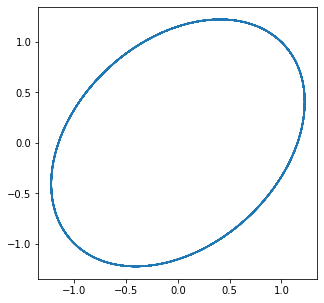

In [17]:
X = level_curve(f1, 1, 1, 4)
Y = X[:, 0]
Z = X[:, 1]
plt.plot(Y, Z); # on obtient bien ce qui est attendu

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [18]:
import math
def No(x):
    return (x[0]**2 + x[1]**2)**0.5
def level_curve2(f, x0, y0, delta = 0.01, N = 10000, eps = eps):
    c = f(x0, y0)                        ##Pour commencer sur un point qui sera bien sur la ligne de niveau partant de x0,y0
    rotation = np.array([[0, 1], [- 1, 0]])
    gradient = delta * grad(f)(x0, y0) / np.sqrt(np.vdot(grad(f)(x0, y0), grad(f)(x0, y0)))
    a_droite = np.dot(rotation, gradient)
    L = np.zeros((N, 2))
    L[0] = x0, y0
    a = 1     #sert à compter le nombre de points qu'il y a dans notre courbe de niveau
    for i in range(N - 1):
        if a == 1 or delta < No(L[i] - L[0]):    #a = 1 car au début, on peut avoir delta<norme(l[1]-L[0]) sans bouclage
            P = L[i] + a_droite
            def F(x, y):
                return np.array([f(x, y) - c, (x - x0)**2 + (y - y0)**2 - delta**2])
            x0, y0=Newton(F, P[0], P[1], eps, 100)
            L[i + 1] = x0, y0
            a += 1
            gradient = delta * grad(f)(x0, y0) / np.sqrt(np.vdot(grad(f)(x0, y0), grad(f)(x0, y0)))
            a_droite = np.dot(rotation, gradient)
        else: 
            break
    P = L[i] + a_droite
    def F(x, y):
        return np.array([f(x, y) - c, (x - x0)**2 + (y - y0)**2 - delta**2])
    x0, y0=Newton(F, P[0], P[1], eps, 100)
    L[i + 1] = x0, y0
    a += 1
    gradient = delta * grad(f)(x0, y0) / np.sqrt(np.vdot(grad(f)(x0, y0), grad(f)(x0, y0)))
    a_droite = np.dot(rotation, gradient)
    return L, a

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

766


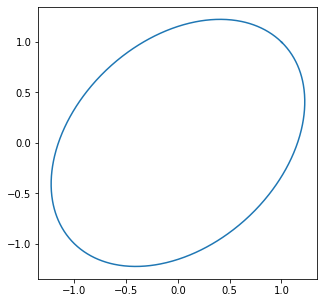

In [19]:
import numpy
X, a = level_curve2(f1, 1, 1)
Y = X[:a, 0]
Z = X[:a, 1]
print(a)   #sans vérification du bouclage, on aurait a = 10 000
plt.plot(Y, Z);

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [20]:
def area_squares(f, c, h, largeur): #on rajoute l'argument largeur qui permet de précisicer la taille du carré 
                        #qu'on prend pour entourer l'ensemble mesuré
    x = np.linspace(- largeur / 2, largeur / 2, int(largeur / h))
    y = np.linspace(- largeur / 2, largeur / 2, int(largeur / h))
    Z = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]) # nous donne un tableau sur 
                        #lequel on peut appliquer f qui comprend toutes les valeurs prises par le couple (x,y) sur le carré
    f = np.vectorize(f)
    M = f(Z[:, 0], Z[:, 1])
    return len(M[M <= c]) * h * h

In [21]:
def f(x, y):
    return x**2 + y**2
area_squares(f, 1, 0.1, 2.2) #test

2.8400000000000003

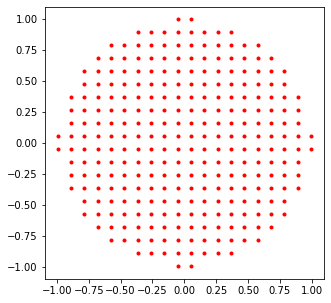

In [22]:
def area_show(f, c, h, largeur):      #fonction pour vérifier qu'on récupère bien la forme de l'intérieur de la courbe de niveau
                            #avec la fonction "area_squares"
    x = np.linspace(- largeur / 2, largeur / 2, int(largeur / h))
    y = np.linspace(- largeur / 2, largeur / 2, int(largeur / h))
    Z = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    f = np.vectorize(f)
    M = f(Z[:, 0], Z[:, 1])
    plt.plot(Z[:, 0][M <= c], Z[:, 1][M <= c], 'r.')

area_show(f, 1, 0.1, 2.2) #l'image obtenue est cohérente 

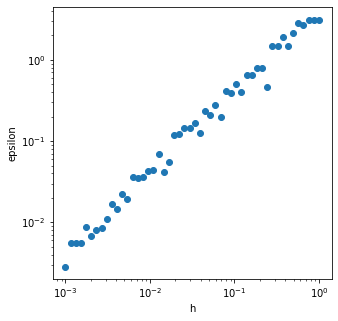

In [23]:
H = - np.linspace(0, 3, 50)
Hcalcul = np.power(10, H) # donne un tableau de différentes valeurs de h pour lesquelles on va calculer l'erreur

epsi = []
for h in Hcalcul:
    epsi += [- area_squares(f, 1, h, 2.2) + np.pi]
plt.xlabel('h');
plt.ylabel('epsilon');
plt.loglog(Hcalcul, epsi, '.');

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [24]:
# nous nous intéressons maintenant aux coins des carrés
# pour être sûr de majorer ou minorer l'aire de l'ensemble en supposant que h est suffisamment petit
# on fait un test pour avoir l'aire des carrés qui sont tous à l'extérieur et ensuite tous à l'intérieur
# on teste pour cela les 4 coins des carrés
# on ne change pas le code initial car les centres des carrés sont en fait les coins de carrés de même aire

def area_squares_encadrement(f, c, h, largeur):
    x = np.linspace(- largeur / 2, largeur / 2, int(largeur / h))
    y = np.linspace(- largeur / 2, largeur / 2, int(largeur / h))
    Z = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    f = np.vectorize(f)
    M = f(Z[:, 0], Z[:, 1])
    Boul = M <= c
    Boul = np.reshape(Boul, (len(x), len(x)))
    a, b = 0, 0
    for i in range(len(x) - 1):
        for j in range(len(x) - 1):
            if (Boul[i, j], Boul[i + 1, j], Boul[i, j + 1], Boul[i + 1, j + 1]) \
            == (False, False, False, False): #test des 4 coins  
                a += 1
    for i in range(len(x) - 1):
        for j in range(len(x) - 1):
            if (Boul[i, j], Boul[i + 1, j], Boul[i, j + 1], Boul[i + 1, j + 1]) == (True, True, True, True) : #test des 4 coins  
                b += 1
    return [b * h * h, 2.2**2 - a * h * h], (2.2**2 - a * h * h - b * h * h ) <= 10**(- 2) 
                    #test pour voir si s'interval est bien plus petit que 0.01


area_squares_encadrement(f, 1, 0.0008, 2.2)

([3.087872, 3.1867520000000007], False)

In [25]:
l = [3.1361388800000003, 3.1460582400000003]
print(np.pi - l[0], l[1] - np.pi)

0.005453773589792821 0.004465586410207223


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

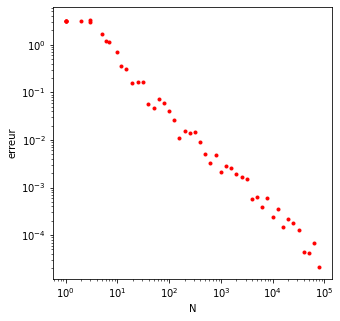

In [26]:
import random 
N = 10**4

# la convergence de Bn vers pi est claire et elle se fait par valeurs inférieure

def aire(N):
    T = np.linspace(0, 2 * np.pi, N)
    x = np.cos(T)
    y = np.sin(T)
    X, Y = random.uniform(- 0.5, 0.5), random.uniform(- 0.5, 0.5)  #on prend un point dans un carré inscrit dans le cercle unité
    S = 0
    for i in range(1, len(x) - 1):    
        a = np.array([X, Y])
        b = np.array([x[i - 1], y[i - 1]])
        c = np.array([x[i], y[i]])
        ba = a - b
        bc = c - b
        U = np.cross(bc, ba) / 2 #le produit vectoriel de bc par ba donne l'aire algébrique du parallélogramme de cotés générateurs bc et ba
        S += U   
    return S    
L = []
Nlist = [int(10**(i / 10)) for i in range(50)]
for v in Nlist:
    L.append(abs(aire(v) - np.pi))
plt.xlabel('N')
plt.ylabel('erreur')
plt.loglog(Nlist, L, 'r.'); #la convergence est exponentielle

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [27]:
T = np.arange(0, 2 * np.pi, 0.0001)
x = np.cos(T)
y = np.sin(T)
X, Y = 2, 2 #Le point 2,2 n'est pas dans l'enveloppe convexe du cercle unité
S = 0
for i in range(1, len(x) - 1):    
    a = np.array([X, Y])
    b = np.array([x[i - 1], y[i - 1]])
    c = np.array([x[i], y[i]])
    ba = a - b
    bc = c - b
    U = np.cross(bc, ba) / 2
    S += U   
S #on voit que le résultat est le bon
# explication cf image affichée à l'éxécution du programme
# l'aire rouge est comptée positivement car elle est parcourue dans le sens trigo tandis que l'aire verte est comptée négativement
# la somme des deux donne donc l'aire de K
# l'approche est donc pertinente même si le point p est à l'extérieur de K

3.1416852847733088

In [28]:
import tkinter as tk
 
fenetre = tk.Tk()
 
photo = tk.PhotoImage(file='prod_vect.png')
 
label = tk.Label(fenetre, image=photo)
label.pack()
 
fenetre.mainloop()

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

6.28304262231049

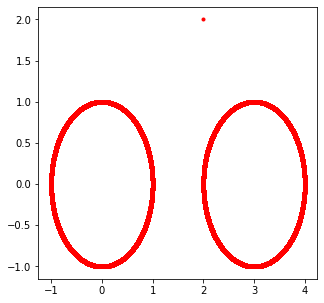

In [29]:
T = np.arange(0, 2 * np.pi, 0.0001)
n = len(T)
X, Y = 2, 2 #Le point 2,2 n'est pas dans l'enveloppe convexe du cercle unité
x = np.empty((2 * len(T) + 1))
y = np.empty((2 * len(T) + 1))
x[:n] = np.cos(T)
y[:n] = np.sin(T)
x[n] = X                ##On prend le point P de calcul de l'aire  comme point de changement de courbe fermée pour ne pas 
y[n] = Y               ## compter l'aire du triangle formé par x[n-1] P x[n+1]
x[n +1: ] = np.cos(T) + 3
y[n+1: ] = np.sin(T)
S = 0
for i in range(1, len(x)-1):    
    a = np.array([X, Y])
    b = np.array([x[i-1], y[i-1]])
    c = np.array([x[i], y[i]])
    ba = a - b
    bc = c - b
    U = np.cross(bc, ba) / 2
    S += U   
plt.plot(x, y, 'r.')
S    # on trouve bien 2*pi

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [ ]:
import random as rd
L = np.empty((len(x), 2))
L[:, 0] = x[:]
L[:, 1] = y[:]

def area_triangles(L):
    lambd = rd.random()
    X, Y = lambd * L[0] + (1 - lambd) * L[len(L) // 2]
    x = L[:, 0]
    y = L[:, 1]
    S = 0
    for i in range(1, len(x)-1):    
        a = np.array([X, Y])
        b = np.array([x[i-1], y[i-1]])
        c = np.array([x[i], y[i]])
        ba = a - b
        bc = c - b
        U = np.cross(bc, ba) / 2
        S += U   
    return S

area_triangles(L)

In [ ]:
# les deux méthodes donnent donc des résultats cohérents
# avantages de la méthode des triangles : 
# - sa complexité est linéaire par rappoort à N
# - la convergence est exponentielle par rapport à N (cf graph)
# désavantage :
# - on n'a pas accés à un encadrement de l'aire recherchée
# avantages de la méthode des carrés :
# - elle permet d'obtenir un encadrement et nous assure donc la précision des résultats
# - sa convergence est exponentielle par rapport à h (cf graph)
# désaventage méthode des carrés : 
# - sa complexité est en O(h**2)